<a href="https://colab.research.google.com/github/gregoriusyuristama/Machine-Learning/blob/main/submission3_animals_yuristama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/andrewmvd/animal-faces')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Your Kaggle Key: Downloading animal-faces.zip to ./animal-faces


100%|██████████| 696M/696M [01:38<00:00, 7.43MB/s]

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import os, subprocess, shutil, pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [4]:
def merge_train_val(folder1, folder2, merged_path):
  ## write an rsync commands to merge the directories
  rsync_cmd = 'rsync' + ' -avzh ' + folder1 + ' ' + folder2 + ' ' + merged_path

  ## run the rsync command
  subprocess.run(rsync_cmd, shell=True)

In [5]:
merge_train_val('/content/animal-faces/afhq/train/', '/content/animal-faces/afhq/val/', '/content/animal-faces/animals/')

In [ ]:
base_dir = '/content/animal-faces/animals'

In [ ]:
datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    brightness_range = [0.6,1.5],
                    zoom_range = 0.2,
                    shear_range = 0.2,
                    fill_mode = 'wrap',
                    validation_split=0.2
                    )

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = datagen.flow_from_directory(
  base_dir,
  target_size=(img_height, img_width),
  color_mode = "rgb",
  class_mode = "categorical",
  subset="training",
  batch_size=batch_size,
  )

val_ds = datagen.flow_from_directory(
  base_dir,
  target_size=(img_height, img_width),
  color_mode = "rgb",
  class_mode = "categorical",
  subset="validation",
  batch_size=batch_size,
  )

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3,  activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)        0

In [10]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
ACCURACY_THRESHOLD = 0.92
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD and logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
          print("\nAkurasi sudah mencapai %2f%%, training berhenti!!" %(ACCURACY_THRESHOLD*100))   
          self.model.stop_training = True

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000003)

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[myCallback(),learning_rate_reduction]
)

Epoch 1/15
404/404 [==============================] - 270s 643ms/step - loss: 0.6629 - accuracy: 0.6774 - val_loss: 0.3804 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 2/15
404/404 [==============================] - 249s 616ms/step - loss: 0.2291 - accuracy: 0.9157 - val_loss: 0.2213 - val_accuracy: 0.9119 - lr: 0.0010
Epoch 3/15
404/404 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.9397
Akurasi sudah mencapai 92.000000%, training berhenti!!
404/404 [==============================] - 247s 613ms/step - loss: 0.1674 - accuracy: 0.9397 - val_loss: 0.1911 - val_accuracy: 0.9277 - lr: 0.0010


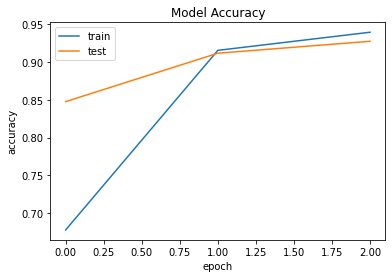

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [15]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('animals.tflite')
tflite_model_file.write_bytes(tflite_model)

9853884